In [29]:
import tensorflow as tf
import pandas as pd 
import numpy as np 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

import seaborn as sns

In [30]:
df = pd.read_csv("/Users/darrenlee/Desktop/portfolio/Data-science/Federated-learning/data/raw/clean_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)
train = df.loc['2012-06-01':].reset_index()
test = df.loc['2012-06-02':].reset_index()

/var/folders/1q/26x3nv656dg2gv4xzbytws5m0000gn/T/ipykernel_1337/4191437680.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test = df.loc['2012-06-02':].reset_index()


In [31]:
train.shape, test.shape

((64863, 23), (61933, 23))

In [32]:
COLUMNS = ['Temperature',
 'Size',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Dept_1',
 'Dept_2',
 'Dept_3',
 'Dept_4',
 'Dept_5',
 'Dept_6',
 'Dept_7',
 'Dept_8',
 'Dept_9',
 'Dept_10',
 'Dept_11',
 'Dept_12',
 'Dept_13',
 'Dept_14',
 'Dept_16',
 'Dept_17',
 'Dept_18',
 'Dept_19',
 'Dept_20',
 'Dept_21',
 'Dept_22',
 'Dept_23',
 'Dept_24',
 'Dept_25',
 'Dept_26',
 'Dept_27',
 'Dept_28',
 'Dept_29',
 'Dept_30',
 'Dept_31',
 'Dept_32',
 'Dept_33',
 'Dept_34',
 'Dept_35',
 'Dept_36',
 'Dept_37',
 'Dept_38',
 'Dept_39',
 'Dept_40',
 'Dept_41',
 'Dept_42',
 'Dept_44',
 'Dept_45',
 'Dept_46',
 'Dept_47',
 'Dept_48',
 'Dept_49',
 'Dept_50',
 'Dept_51',
 'Dept_52',
 'Dept_54',
 'Dept_55',
 'Dept_56',
 'Dept_58',
 'Dept_59',
 'Dept_60',
 'Dept_65',
 'Dept_67',
 'Dept_71',
 'Dept_72',
 'Dept_74',
 'Dept_77',
 'Dept_78',
 'Dept_79',
 'Dept_80',
 'Dept_81',
 'Dept_82',
 'Dept_83',
 'Dept_85',
 'Dept_87',
 'Dept_90',
 'Dept_91',
 'Dept_92',
 'Dept_93',
 'Dept_94',
 'Dept_95',
 'Dept_96',
 'Dept_97',
 'Dept_98',
 'Dept_99',
 'IsHoliday_False',
 'IsHoliday_True',
 'Super_Bowl_True',
 'Super_Bowl_False',
 'Type_A',
 'Type_B',
 'Type_C',
 'Labor_Day_False',
 'Labor_Day_True',
 'Thanksgiving_True',
 'Thanksgiving_False',
 'Christmas_True',
 'Christmas_False'
 ]

In [33]:
X_train = train.drop(['Weekly_Sales'], axis=1)
y_train = train['Weekly_Sales']

X_test = test.drop(['Weekly_Sales'], axis=1)
y_test = test['Weekly_Sales']

In [34]:
CATEGORICAL_FEATURE_KEYS = [
    'Dept',
    'IsHoliday',
    "Super_Bowl",
    "Type",
    "Labor_Day",
    "Thanksgiving",
    "Christmas"
]

NUMERIC_FEATURE_KEYS = [
    "Temperature",
    "Size",
    "Fuel_Price",
    "MarkDown1",
    "MarkDown2",
    "MarkDown3",
    "MarkDown4",
    "MarkDown5",
    "CPI",
]

In [35]:
ct = ColumnTransformer(
    [("Numeric", StandardScaler(), NUMERIC_FEATURE_KEYS),
     ("Categorical", OneHotEncoder(handle_unknown='infrequent_if_exist'), CATEGORICAL_FEATURE_KEYS)
    ])

In [36]:
pipeline = Pipeline(steps=[('preprocessor', ct)])
X_train_trans = pipeline.fit_transform(X_train)
X_test_trans = pipeline.transform(X_test)
trans_col = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(CATEGORICAL_FEATURE_KEYS)

In [37]:
X_train_trans

<64863x99 sparse matrix of type '<class 'numpy.float64'>'
	with 1037808 stored elements in Compressed Sparse Row format>

In [38]:
X_train_nn = X_train_trans.toarray()
X_train_nn = pd.DataFrame(X_train_nn, columns = NUMERIC_FEATURE_KEYS + trans_col.tolist())

X_test_nn = X_test_trans.toarray()
X_test_nn = pd.DataFrame(X_test_nn, columns = NUMERIC_FEATURE_KEYS + trans_col.tolist())
X_train_nn.shape, X_test_nn.shape

((64863, 99), (61933, 99))

In [39]:
for column in COLUMNS:
    if column not in X_train_nn.columns:
        X_train_nn[column] = 0
    if column not in X_test_nn.columns:
        X_test_nn[column] = 0
X_train_nn.shape, X_test_nn.shape

((64863, 102), (61933, 102))

In [40]:
X_train_nn.columns

Index(['Temperature', 'Size', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Dept_1',
       ...
       'Type_A', 'Type_B', 'Type_C', 'Labor_Day_False', 'Labor_Day_True',
       'Thanksgiving_False', 'Christmas_False', 'Super_Bowl_True',
       'Thanksgiving_True', 'Christmas_True'],
      dtype='object', length=102)

In [41]:
# X_train_nn = X_train_nn.toarray()
X_train_nn = tf.convert_to_tensor(X_train_nn)
y_train_nn = tf.convert_to_tensor(y_train)

# X_test_nn = X_test_nn.toarray()
X_test_nn = tf.convert_to_tensor(X_test_nn)
y_test_nn = tf.convert_to_tensor(y_test)

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, input_shape=(None,102)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(2000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    # loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[
        tf.keras.metrics.mean_squared_error,
        tf.keras.metrics.mean_absolute_error,
    ],
)

In [43]:
history = model.fit(
    X_train_nn, y_train_nn, epochs=10
)

Epoch 1/10


2022-12-16 14:36:31.797598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2027/2027 [==============================] - 33s 16ms/step - loss: 5920.4590 - mean_squared_error: 130291688.0000 - mean_absolute_error: 5920.4590
Epoch 2/10
2027/2027 [==============================] - 32s 16ms/step - loss: 4477.1597 - mean_squared_error: 75350632.0000 - mean_absolute_error: 4477.1597
Epoch 3/10
2027/2027 [==============================] - 32s 16ms/step - loss: 4140.0732 - mean_squared_error: 65826192.0000 - mean_absolute_error: 4140.0732
Epoch 4/10
2027/2027 [==============================] - 32s 16ms/step - loss: 3921.1724 - mean_squared_error: 59967740.0000 - mean_absolute_error: 3921.1724
Epoch 5/10
2027/2027 [==============================] - 32s 16ms/step - loss: 3783.8665 - mean_squared_error: 56023036.0000 - mean_absolute_error: 3783.8665
Epoch 6/10
2027/2027 [==============================] - 27s 13ms/step - loss: 3660.9854 - mean_squared_error: 53456128.0000 - mean_absolute_error: 3660.9854
Epoch 7/10
2027/2027 [==============================] - 26s 13ms/ste

<AxesSubplot: >

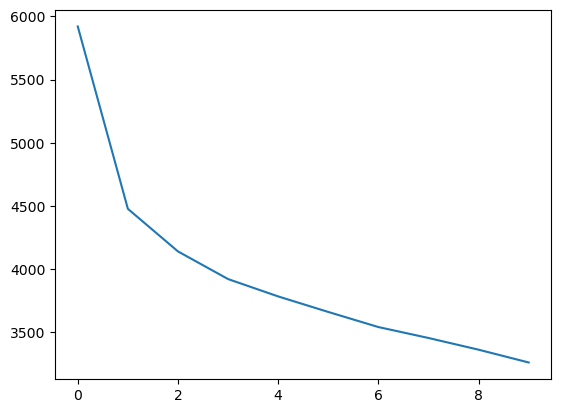

In [44]:
sns.lineplot(history.history['loss'])

In [45]:
model.evaluate(X_test_nn, y_test_nn)

  19/1936 [..............................] - ETA: 11s - loss: 4729.3643 - mean_squared_error: 102525240.0000 - mean_absolute_error: 4729.3643

2022-12-16 14:41:43.829149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1936/1936 [==============================] - 11s 6ms/step - loss: 3017.1824 - mean_squared_error: 41313216.0000 - mean_absolute_error: 3017.1824


[3017.182373046875, 41313216.0, 3017.182373046875]

# Store level accuracy

In [46]:
%cd ..
%ls

/Users/darrenlee/Desktop/portfolio/Data-science/Federated-learning
README.md  conda.yml  data/      notebooks/ src/       src1/


In [49]:
from src1.data import load_data
from src1.model import Model
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
df = pd.DataFrame()
failed = []

In [51]:
for i in range(0, 45):
    # path = os.path.join("./data/store_level_data/", "store_" + str(i))
    X_train, y_train, X_test, y_test = load_data(str(i+1), data_dir="./data/store_level_data/")
    try:
        loss, train_mean_squared_error, train_mean_absolute_error = model.evaluate(
                X_train, y_train
            )
        loss, test_mean_squared_error, test_mean_absolute_error = model.evaluate(
                X_test, y_test
            )

        df_sub = pd.DataFrame({"Store":[str(i+1)],
                            "train_mse": [train_mean_squared_error],
                            "train_mae":[train_mean_absolute_error],
                            "test_mse": [test_mean_squared_error],
                            "test_mae":[test_mean_absolute_error],
                            "training_history": history }
                            )
        df = pd.concat([df, df_sub])
    except:
        failed.append(str(i+1))

44/44 [==============================] - 0s 6ms/step - loss: 11682.7197 - mean_squared_error: 490120384.0000 - mean_absolute_error: 11682.7197


In [53]:
failed

['13', '14', '15', '28', '29']

In [55]:
%ls

README.md  conda.yml  data/      notebooks/ src/       src1/


In [57]:
df.to_csv("./data/performance/centralised_result.csv", index=False)